# Neural Networks Using Tensorflow (Basics)
This notebook is based on the deeplearning.ai Hyper-parameter course's Week 3 Lab.
* Made by: Muhammad Hamza
* Github: muhammadhamzach

Importing the necessary libraries including Tensorflow v2

In [1]:
import tensorflow as tf
import numpy as np
import h5py
import math
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
tf.compat.v1.disable_eager_execution()

### Loading Dataset
We load the dataset from the same directory. The two files loaded are for both training and test sets.
As usual you flatten the image dataset, then normalize it by dividing by 255. On top of that, you will convert each label to a one-hot vector as shown in Figure 1. Run the cell below to do so.

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    # Flatten the training and test images
    X_train_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
    X_test_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
    
    # Normalize image vectors
    X_train = X_train_flatten/255.
    X_test = X_test_flatten/255.
    # Convert training and test labels to one hot matrices
    Y_train = convert_to_one_hot(train_set_y_orig, classes.shape[0])
    Y_test = convert_to_one_hot(test_set_y_orig, classes.shape[0])
    
    return X_train, Y_train,X_test, Y_test, classes

### Using One Hot encodings
This is a "one hot" encoding i.e. in the converted representation exactly one element of each column is "hot" (meaning set to 1).

In [3]:
def convert_to_one_hot(Y, C):
    
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

### Create placeholders

Now to create placeholders for `X` and `Y`. This will allow you to later pass your training data in when you run your session.

In [4]:
def create_placeholders(n_x, n_y):
    ##Creates the placeholders for the tensorflow session.

    X = tf.compat.v1.placeholder(tf.float32, [n_x, None], name="X")
    Y = tf.compat.v1.placeholder(tf.float32, [n_y, None], name="Y")
    
    return X, Y

### Mini-Batch Gradient descent

Let's learn how to build mini-batches from the training set (X, Y).

There are two steps:
- **Shuffle**: Create a shuffled version of the training set (X, Y) as shown below. Each column of X and Y represents a training example. Note that the random shuffling is done synchronously between X and Y. Such that after the shuffling the $i^{th}$ column of X is the example corresponding to the $i^{th}$ label in Y. The shuffling step ensures that examples will be split randomly into different mini-batches. 

- **Partition**: Partition the shuffled (X, Y) into mini-batches of size `mini_batch_size`. Note that the number of training examples is not always divisible by `mini_batch_size`. The last mini batch might be smaller, but you don't need to worry about this. 

In [5]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):    
    #Creates a list of random minibatches from (X, Y)

    m = X.shape[1]
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

### Initializing the parameters

Next task is to initialize the parameters in tensorflow. Implement the function below to initialize the parameters in tensorflow. You are going use Xavier Initialization for weights and Zero Initialization for biases.


In [6]:
def initialize_parameters(layer_dims):
    ## Initializes parameters to build a neural network with tensorflow. The shapes are:

    tf.compat.v1.random.set_random_seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        
        parameters['W' + str(l)] = tf.compat.v1.get_variable('W' + str(l), [layer_dims[l],layer_dims[l-1]], initializer = tf.keras.initializers.GlorotUniform(seed = 1))
        parameters['b' + str(l)] = tf.compat.v1.get_variable('b' + str(l), [layer_dims[l], 1], initializer = tf.zeros_initializer())
        np.zeros((layer_dims[l], 1))
    
    return parameters

### Computing the Cost

You can also use a built-in function to compute the cost of your neural network. So instead of needing to write code to compute this as a function of $a^{[2](i)}$ and $y^{(i)}$ for i=1...m: 
$$ J = - \frac{1}{m}  \sum_{i = 1}^m  \large ( \small y^{(i)} \log a^{ [2] (i)} + (1-y^{(i)})\log (1-a^{ [2] (i)} )\large )\small\$$

you can do it in one line of code in tensorflow!

In [7]:
def compute_cost(Z, Y):
    # Computes the cost

    logits = tf.transpose(Z)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost

### Forward propagation in tensorflow 

You will now implement the forward propagation module in tensorflow. The function will take in a dictionary of parameters and it will complete the forward pass. It is important to note that the forward propagation stops at `Z`. The reason is that in tensorflow the last linear layer output is given as input to the function computing the loss. Therefore, you don't need `AL`!

In [8]:
def forward_propagation(X, parameters):
    ##Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX

    A = X
    L = len(parameters) // 2  
    
    tf.compat.v1.random.set_random_seed(1)
      
    for l in range(1, L+1):     
        Z = tf.add(tf.matmul(parameters['W'+str(l)],A),parameters['b'+str(l)])
        if l != L:
            A = tf.nn.relu(Z)
 
    return Z

### Predictions

Use your model to predict by building predict().
Use forward propagation to predict results.

In [9]:
def predict(X, parameters):
    
    params = {}
    L = len(parameters) // 2 
    
    for l in range(1, L):    
        params['W' + str(l)] = tf.convert_to_tensor(parameters['W' + str(l)])
        params['b' + str(l)] = tf.convert_to_tensor(parameters['b' + str(l)])
    
    x = tf.placeholder("float", [X.shape[0], 1])
    
    Z = forward_propagation(x, params)
    p = tf.argmax(Z)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
    
    return predictions

### Building the model

Now, we will bring it all together! 

In [10]:
def tensor_model(X_train, Y_train, X_test, Y_test, layer_dims, optimizer="gd", beta1= 0.9, beta2=0.999, epsilon=1e-8, learning_rate = 0.0001,num_epochs = 1500, minibatch_size = 32, print_cost = True):
    ##Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.compat.v1.random.set_random_seed(1)
    seed = 3                                         
    (n_x, m) = X_train.shape                          
    n_y = Y_train.shape[0]
    costs = []
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters(layer_dims)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    if optimizer == "gd":
        optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
    elif optimizer == "adam":
        optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = learning_rate, beta1=beta1, beta2=beta2, epsilon = epsilon).minimize(cost)
    
    # Initialize all the variables
    init = tf.compat.v1.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.compat.v1.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0
            #num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                
                #The line that runs the graph on a minibatch.
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / minibatch_size

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.figure(1)
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        parameters = sess.run(parameters)

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

### Main Function
Here we will call our Neural Network made using Tensor Flow and see the results.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Cost after epoch 0: 1.924667
Cost after epoch 100: 0.766357
Cost after epoch 200: 0.527253
Cost after epoch 300: 0.365863
Cost after epoch 400: 0.236924
Cost after epoch 500: 0.146674
Cost after epoch 600: 0.094273
Cost after epoch 700: 0.067775
Cost after epoch 800: 0.033554
Cost after epoch 900: 0.019139
Cost after epoch 1000: 0.011892
Cost after epoch 1100: 0.006809
Cost after epoch 1200: 0.006445
Cost after epoch 1300: 0.003129
Cost after epoch 1400: 0.002760


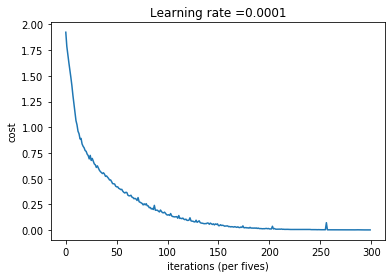

Train Accuracy: 1.0
Test Accuracy: 0.85833335


In [11]:
X_train, Y_train, X_test, Y_test, classes = load_dataset()
m = X_train.shape[1]

layer_dims = [X_train.shape[0], 25, 12, classes.shape[0]]  #dimesions of the neural network layer
learning_rate = 0.0001                      #alpha learning rate of the system
num_epochs = 1500                           #number of iterations 
minibatch_size = 32                         #use m for Batch Gradient Descent instead of Mini Batch Gradient Descent

optimizer = "adam"                            #gradient descent type ("gd" or "adam" available)
beta1 = 0.9                                 #momentum parameter for Adam Optimizer
beta2 = 0.999                               #momentum parameter for Adam Optimizer
epsilon=10e-8                               #for Adam Optimizer


parameters = tensor_model(X_train, Y_train, X_test, Y_test, layer_dims, optimizer, beta1,beta2,epsilon, learning_rate, num_epochs, minibatch_size)